In [64]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
import itertools
from functools import partial
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import metrics, model_selection
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Avenir']
mpl.rcParams['font.size'] = 12
# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import viz
import validate

DATASET = 'sim'
SPLIT_SEED = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
def get_sim_data(size=500, cov_scale=1, noise_scale=2, noise_vars=20):
    X_1 = np.zeros((size, 2 + noise_vars))
    X_2 = np.zeros((size, 2 + noise_vars))
    X_3 = np.zeros((size, 2 + noise_vars))
    X_4 = np.zeros((size, 2 + noise_vars))

    X_1[:, 0] = np.random.normal(loc=0, scale=cov_scale, size=size)
    X_2[:, 0] = np.random.normal(loc=2, scale=cov_scale, size=size)
    X_3[:, 0] = np.random.normal(loc=4, scale=cov_scale, size=size)
    X_4[:, 0] = np.random.normal(loc=6, scale=cov_scale, size=size)

    X_1[:, 1] = np.random.normal(loc=0, scale=cov_scale, size=size)
    X_2[:, 1] = np.random.normal(loc=0, scale=cov_scale, size=size)
    X_3[:, 1] = np.random.normal(loc=2, scale=cov_scale, size=size)
    X_4[:, 1] = np.random.normal(loc=2, scale=cov_scale, size=size)

    y_1 = X_1[:, 1] > 0
    y_2 = X_2[:, 1] > 0
    y_3 = X_3[:, 1] > 2
    y_4 = X_4[:, 1] > 2

    for i in range(2, 2 + noise_vars):
        X_1[:, i] = np.random.normal(scale=noise_scale, size=size)
        X_2[:, i] = np.random.normal(scale=noise_scale, size=size)
        X_3[:, i] = np.random.normal(scale=noise_scale, size=size)
        X_4[:, i] = np.random.normal(scale=noise_scale, size=size)

    if noise_scale > 0:
        #add noise to covariates
        for X in [X_1, X_2, X_3, X_4]:
            X[:, 0] += np.random.normal(scale=noise_scale, size=X.shape[0])
            X[:, 1] += np.random.normal(scale=noise_scale, size=X.shape[0])
        # 2-2 for 6.4%

    # X_1[:, 1] += np.random.normal(loc=0.5, scale=1, size=X.shape[0])
    # X_2[:, 1] += np.random.normal(loc=-0.5, scale=1, size=X.shape[0])
    # X_3[:, 1] += np.random.normal(loc=0.5, scale=1, size=X.shape[0])
    # X_4[:, 1] += np.random.normal(loc=-0.5, scale=1, size=X.shape[0])
    
    X = np.vstack((X_1, X_2, X_3, X_4))
    y = np.concatenate((y_1, y_2, y_3, y_4))
    y_prop = np.concatenate((
        np.zeros(size), np.ones(size), np.ones(size) * 2, np.ones(size) * 3))

    return X, y, y_prop

In [3]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None, model_name=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        if 'pecarn' in model_name.lower():
            plt.plot(all_stats['sens'][0], all_stats['spec'][0], '.-', label=model_name)
        else:
            plt.plot(1 - np.array(all_stats['spec']), all_stats['sens'],  '.-', label=model_name)
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

In [4]:
results = defaultdict(lambda:[])
columns = ['acc', 'auc', 'aps', 'f1', 'args']

def log_results(model, model_name, X_test, y_test, model_args=None):
    pred_proba_args = (X_test,)
    
    # spec_scorer_list = [validate.make_best_spec_high_sens_scorer(sens) for sens in [0.9, 0.92, 0.94, 0.96, 0.98]]
    # spec_scores = [scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]) for scorer in spec_scorer_list]
    acc = metrics.accuracy_score(y_test, model.predict(X_test))
    auc = metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    apc = metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    f1 = metrics.f1_score(y_test, model.predict(X_test))
    results[model_name] = [acc, auc, apc, f1, model_args]

In [5]:
class TransferTree:
    def __init__(self, models, y_prop):
        self.models = models
        self.y_prop = y_prop

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        for i in range(len(self.models)):
            preds_proba[self.y_prop == i] = self.models[i].predict_proba(X[self.y_prop == i])
        return preds_proba

100%|██████████| 7/7 [00:00<00:00, 1378.54it/s]


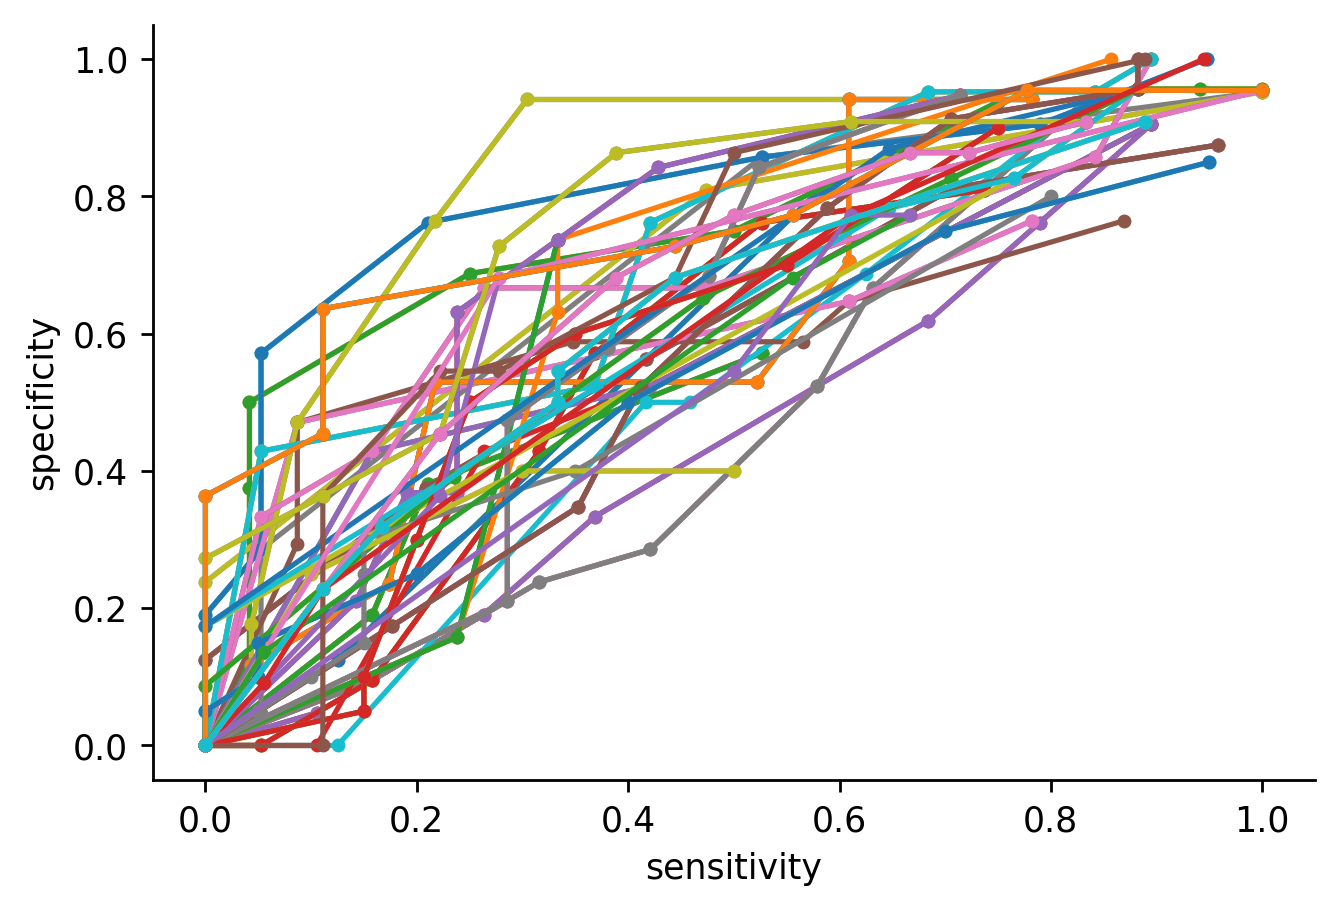

In [8]:
for SIM_SEED in range(10):
    RESULT_PATH = f'notebooks/transfertree/results/{DATASET}/seed_{SIM_SEED}'
    if not os.path.exists(RESULT_PATH):
        os.makedirs(RESULT_PATH)
    def predict_and_save(model, X_test, y_test, model_name, group):
        '''Plots cv and returns cv, saves all stats
        '''
        results = {}
        for x, y, suffix in zip([X_test],
                                [y_test],
                                ['_tune']):
            stats, threshes = all_stats_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
            for stat in stats.keys():
                results[stat + suffix] = stats[stat]
            results['threshes' + suffix] = threshes
            results['acc'] = metrics.accuracy_score(y, model.predict(x))
            results['f1'] = metrics.f1_score(y, model.predict(x))
            if type(model) not in {TransferTree}:
                results['params'] = model.get_params()
        if not os.path.exists(oj(RESULT_PATH, group)):
            os.mkdir(oj(RESULT_PATH, group))
        pkl.dump(results, open(oj(RESULT_PATH, group, model_name + '.pkl'), 'wb'))
        return stats, threshes

    np.random.seed(SIM_SEED)
    X, y, y_prop= get_sim_data(size=40, noise_vars=10)
    X_prop_raw = X
    fnames_prop, feature_names = None, None
    X_df = pd.DataFrame(X, columns=feature_names)

    X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
    X_prop = X_df_prop_raw.values
    X_prop_train_full, X_prop_test, y_prop_train_full, y_prop_test, y_train_full, y_test = model_selection.train_test_split(
        X_prop, y_prop, y, test_size=0.25, random_state=SPLIT_SEED)

    prop_model = LogisticRegressionCV(Cs=10, penalty='l2', solver='liblinear', scoring='average_precision', cv=10)
    prop_model.fit(X_prop_train_full, y_prop_train_full)
    prop_scores_train_full = prop_model.predict_proba(X_prop_train_full)

    best_models = {}
    X_train_full = X_prop_train_full

    best_models['cart_all'] = DecisionTreeClassifier(max_leaf_nodes=4).fit(X_train_full, y_train_full)
    best_models['figs_all'] = imodels.FIGSClassifier(max_rules=4).fit(X_train_full, y_train_full)
    best_models['tao_all'] = imodels.TaoTreeClassifier(n_iters=1, model_args={'max_leaf_nodes': 4}).fit(X_train_full, y_train_full)

    for group in range(4):
        X_group = X_train_full[y_prop_train_full == group]
        y_group = y_train_full[y_prop_train_full == group]

        best_models[f'cart_{group}'] = DecisionTreeClassifier(max_leaf_nodes=2).fit(X_group, y_group)
        best_models[f'pcart_{group}'] = DecisionTreeClassifier(max_leaf_nodes=2).fit(
            X_train_full, y_train_full, sample_weight=prop_scores_train_full[:, group])
        best_models[f'figs_{group}'] = imodels.FIGSClassifier(max_rules=1).fit(X_group, y_group)
        best_models[f'pfigs_{group}'] = imodels.FIGSClassifier(max_rules=1).fit(
            X_train_full, y_train_full, sample_weight=prop_scores_train_full[:, group])
        best_models[f'tao_{group}'] = imodels.TaoTreeClassifier(n_iters=1, model_args={'max_leaf_nodes': 2}).fit(X_group, y_group)

    for model_name in ['pcart', 'pfigs', 'figs', 'tao', 'cart']:
        best_models[f'{model_name}_combine'] = TransferTree(
            [best_models[f'{model_name}_{i}'] for i in range(4)], y_prop_test)
    
    for model_name in ['cart_all', 'figs_all', 'tao_all', 'pcart_combine', 'pfigs_combine', 'cart_combine', 'figs_combine', 'tao_combine']:
        predict_and_save(best_models[f'{model_name}'], X_prop_test, y_test, f'{model_name}', 'all')
    
    pkl.dump(best_models, open(oj(RESULT_PATH, 'best_models.pkl'), 'wb'))

### Visualizing best models

In [12]:
best_models = pkl.load(open(f'notebooks/transfertree/results/sim/seed_0/best_models.pkl', 'rb'))

In [13]:
def vizfigs(dct, name):
    dct[name].feature_names_ = feature_names
    print(dct[name])

In [14]:
vizfigs(best_models, 'pfigs_0')

------------
X_4 <= 0.391 (Tree #0 root)
	Val: 0.297 (leaf)
	Val: 0.631 (leaf)



In [15]:
vizfigs(best_models, 'pfigs_1')

------------
X_1 <= 2.674 (Tree #0 root)
	Val: 0.367 (leaf)
	Val: 0.820 (leaf)



In [16]:
vizfigs(best_models, 'pfigs_2')

------------
X_4 <= 0.501 (Tree #0 root)
	Val: 0.252 (leaf)
	Val: 0.662 (leaf)



In [17]:
vizfigs(best_models, 'pfigs_3')

------------
X_10 <= -3.234 (Tree #0 root)
	Val: 0.005 (leaf)
	Val: 0.505 (leaf)



In [18]:
vizfigs(best_models, 'figs_0')

------------
X_4 <= 0.196 (Tree #0 root)
	Val: 0.278 (leaf)
	Val: 0.818 (leaf)



In [19]:
vizfigs(best_models, 'figs_1')

------------
X_3 <= -1.440 (Tree #0 root)
	Val: 0.857 (leaf)
	Val: 0.292 (leaf)



In [20]:
vizfigs(best_models, 'figs_2')

------------
X_4 <= 0.488 (Tree #0 root)
	Val: 0.190 (leaf)
	Val: 0.727 (leaf)



In [21]:
vizfigs(best_models, 'figs_3')

------------
X_1 <= 0.963 (Tree #0 root)
	Val: 0.000 (leaf)
	Val: 0.550 (leaf)



### understanding propensity model

- main features that determine scores

In [5]:
nonzero_ind = np.nonzero(prop_model.coef_[0])
nonzero_ind_sorted = nonzero_ind[0][np.argsort(prop_model.coef_[0][nonzero_ind])]
prop_model_coefs = pd.DataFrame(prop_model.coef_[0][nonzero_ind_sorted], index=np.arange(len(prop_model.coef_[0]))[nonzero_ind_sorted])

NameError: name 'prop_model' is not defined

In [23]:
prop_model_coefs.style.background_gradient()

,0
0,-0.018230
1,-0.007889
6,-0.001031
4,-0.001027
10,-0.000324
2,0.000110
3,0.000613
5,0.000636
7,0.000839
9,0.000849


- distribution of scores

<AxesSubplot:xlabel='prop_score', ylabel='Density'>

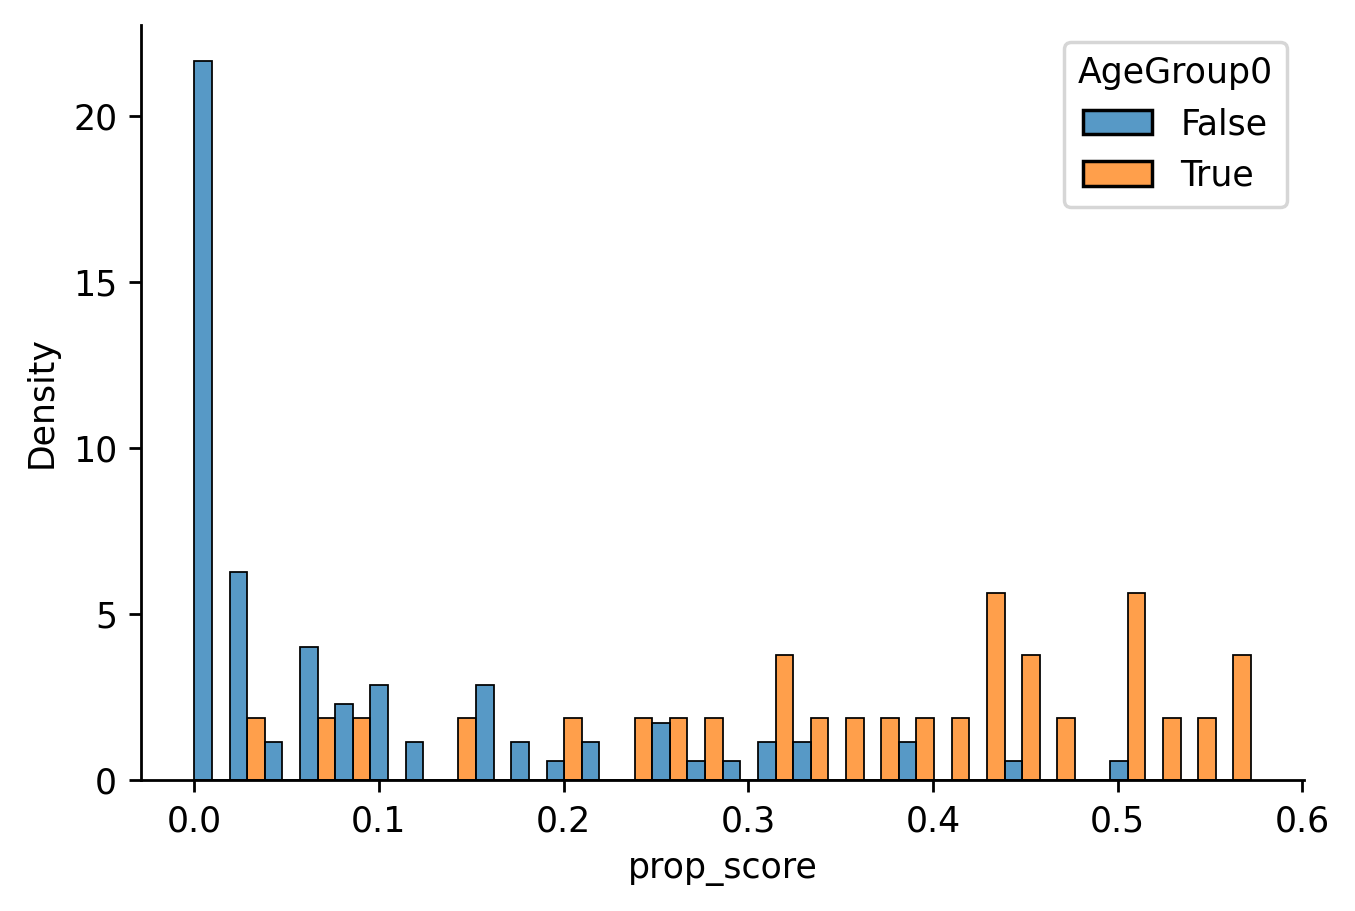

In [24]:
X_df_prop_raw_train_full, X_df_test = model_selection.train_test_split(X_df_prop_raw, test_size=0.25, random_state=SPLIT_SEED)
X_df_prop_raw_train_full['prop_score'] = prop_scores_train_full[:, 3]
X_df_prop_raw_train_full['AgeGroup0'] = y_prop_train_full == 3
sns.histplot(data=X_df_prop_raw_train_full, x='prop_score', hue='AgeGroup0', multiple='dodge', stat="density", 
             bins=30, common_norm=False)

## viz sim data

In [57]:
X_viz, y_viz, y_prop_viz = get_sim_data(
    5000, cov_scale=0.4, noise_scale=0, noise_vars=0)

In [58]:
sim_viz_df = pd.DataFrame(X_viz)

In [59]:
sim_viz_df['Class'] = y_viz.astype(int)
sim_viz_df['y_prop'] = y_prop_viz

In [60]:
# sim_viz_df

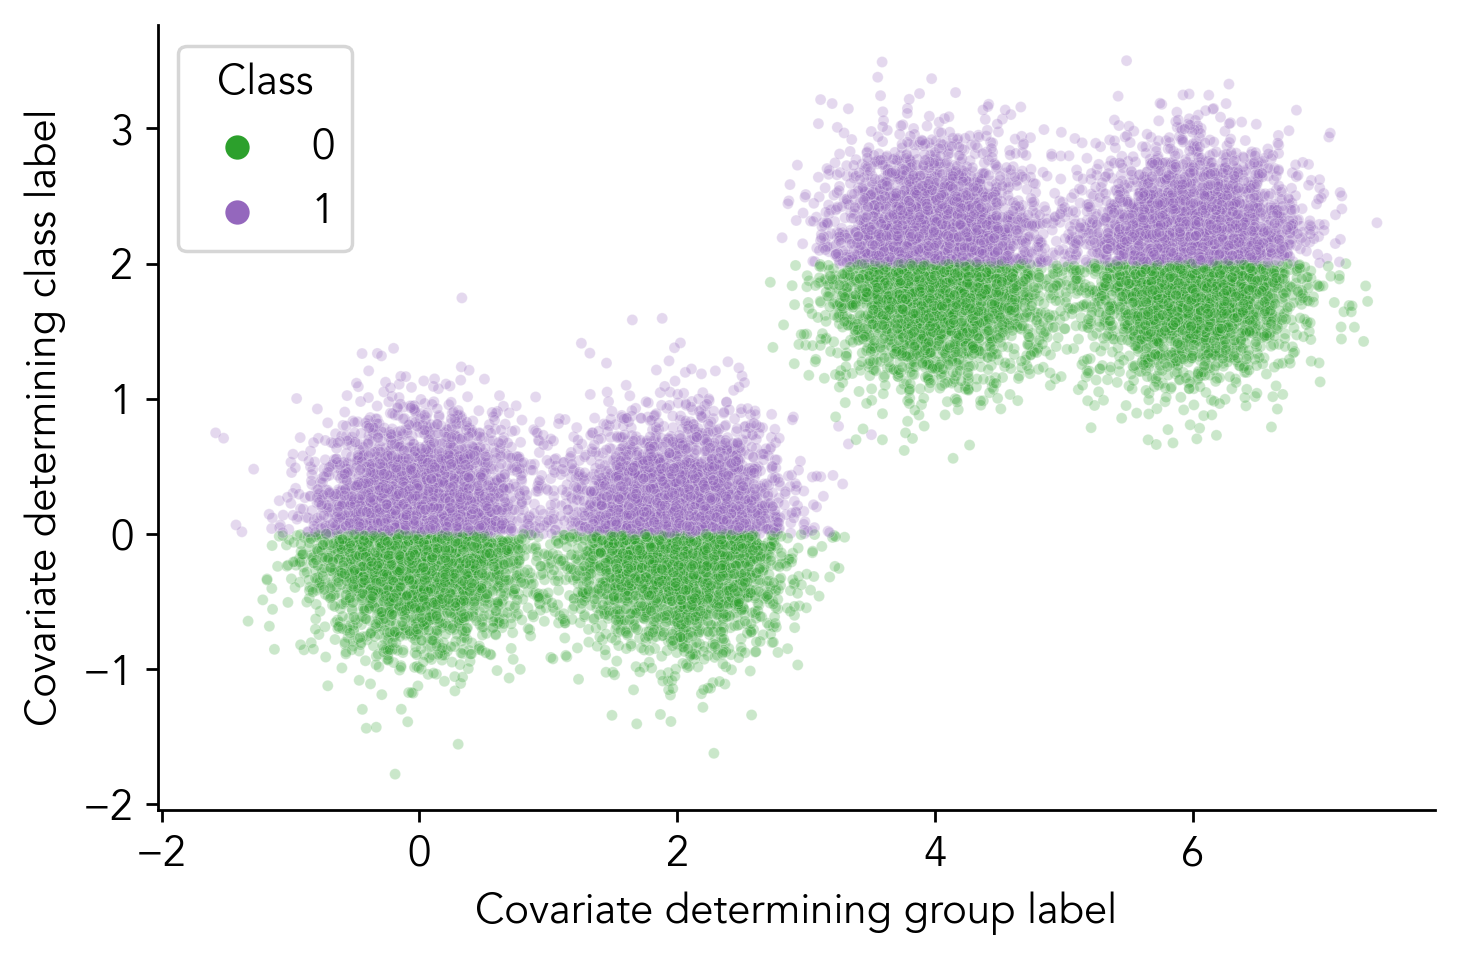

In [65]:
for i in range(4):
    sns.scatterplot(data=sim_viz_df[sim_viz_df['y_prop'] == i], 
        x=0, y=1, hue='Class', alpha=0.25, legend=i==3, s=10, 
        palette=[sns.color_palette()[2], sns.color_palette()[4]])
plt.xlabel('Group variable')
plt.xlabel('Covariate determining group label')
plt.ylabel('Covariate determining class label')
# plt.title('First 2 covariates of simulation data')
plt.tight_layout()
plt.savefig('simulation_data.pdf')